In [1]:
import sys
sys.path.append("..")

from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage

In [2]:
from src.data.dataset import CRBBDataset

crbbd = CRBBDataset(rxn_files=['../data/raw/rxn.txt'], 
                    bb_files=['../data/raw/EnamineHighFidFrags.sdf'], 
                    force_reload=True,
                    maxseqlen=2)

Creating building block dataset...


Processing...


Loading building blocks...


100%|██████████| 1920/1920 [00:02<00:00, 734.05it/s]

Creating conformers for building blocks...



100%|██████████| 1920/1920 [00:01<00:00, 1496.14it/s]


Featurizing building blocks...


100%|██████████| 1920/1920 [00:01<00:00, 998.18it/s] 


Featurizing building block conformers...


100%|██████████| 1920/1920 [00:04<00:00, 376.80it/s]
Done!


Creating reaction dataset...


Processing...


Loading reactions...
Featurizing reactions...


100%|██████████| 2/2 [00:00<00:00, 6218.39it/s]
Done!
Processing...


Matching building blocks and reactions...


100%|██████████| 1920/1920 [00:00<00:00, 6016.55it/s]


Constructing searcher for every rxn reactant...


100%|██████████| 2/2 [00:00<00:00, 415.20it/s]


Constructing conformer searcher for every building block...


100%|██████████| 1920/1920 [00:00<00:00, 6024.50it/s]
Done!


In [3]:
crbbd.pregenerate_data(multiplier=2, clear=True, n_proc=12)
crbbd.save_pregen()

crbbd.load_pregen()

Pre-generating data for dataset...


100%|██████████| 552/552 [00:05<00:00, 79.26it/s] 


In [6]:
rxn_idx = 1

result = crbbd.sample_rxnresult(crbbd.rxnids[rxn_idx])
IPythonConsole.drawMol3D(result[0]+[result[1]])

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [4]:
crbbd[0]

CRBBOutput(lig0_feats=(Data(x=[15, 6], edge_index=[2, 30], y=[1, 12]), Data(y=[1, 11], pos=[15, 3])), rsfeats_2d=[Data(x=[15, 6], edge_index=[2, 30], y=[1, 12]), Data(x=[21, 6], edge_index=[2, 42], y=[1, 12])], rsfeats_3d=[Data(y=[1, 11], pos=[15, 3]), Data(y=[1, 11], pos=[21, 3])], rslengths=2, terminate=tensor([ True, False]), pfeats=(Data(x=[30, 6], edge_index=[2, 64], y=[1, 12]), Data(y=[1, 11], pos=[30, 3])), rxnfeats=tensor([0, 0, 0,  ..., 0, 0, 0]))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.nn.utils import rnn

import torch_geometric as pyg
import torch_geometric.nn as pygnn
from torch_geometric.data import Data, Batch

import lightning as L

from src.data.dataset.crbbdataset import CRBBOutput

from typing import List

class RXNVariationalEncoder(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, encode_dim: int):
        super().__init__()

        self.R_enc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, encode_dim)
        )

        self.R_mu = nn.Linear(encode_dim, encode_dim)
        self.R_logvar = nn.Linear(encode_dim, encode_dim)

        self.dummy = nn.Parameter(torch.zeros(1), requires_grad=False)

    def forward(self, batch: CRBBOutput):
        Rx = batch.rxnfeats.type(self.dummy.dtype)
        Rx = self.R_enc(Rx)
        return Rx

    def encode(self, Rx):
        return self.R_enc(Rx)
    
    def reparameterize(self, Rx):
        mu = self.R_mu(Rx)
        logvar = self.R_logvar(Rx)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std, mu, logvar
    
class ProductVariationalEncoder(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, encode_dim: int):
        super().__init__()

        self.pg_enc = pygnn.GIN(input_dim, hidden_dim, 3, hidden_dim)
        self.px_enc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, encode_dim),
        )

        self.p_mu = nn.Linear(encode_dim, encode_dim)
        self.p_logvar = nn.Linear(encode_dim, encode_dim)

        self.dummy = nn.Parameter(torch.zeros(1), requires_grad=False)
    
    def forward(self, batch: CRBBOutput):
        pg = batch.pfeats[0]
        px = self.encode(pg)
        return px

    def encode(self, pg: Data):
        px = self.pg_enc.forward(pg.x.type(self.dummy.dtype), 
                                 pg.edge_index)
        px = pygnn.global_add_pool(px, pg.batch)
        px = self.px_enc(px)
        return px
    
    def reparameterize(self, px):
        mu = self.p_mu(px)
        logvar = self.p_logvar(px)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std, mu, logvar

class ReactantEncoder(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, encode_dim: int,
                 max_seqlen: int = 5):
        super().__init__()

        self.rg_enc = pygnn.GIN(input_dim, hidden_dim, 3, hidden_dim)
        self.rx_enc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, encode_dim),
        )

        self.dummy = nn.Parameter(torch.zeros(1), requires_grad=False)

        self.max_seqlen = max_seqlen
    
    def forward(self, batch: CRBBOutput):
        rg: Data = Batch.from_data_list(batch.rsfeats_2d)
        rx = self.encode(rg.x, rg.edge_index, rg.batch)
        return rx

    def encode(self, rx, edge_index, batch):
        rx = self.rg_enc.forward(rx.type(self.dummy.dtype), 
                                 edge_index)
        rx = pygnn.global_add_pool(rx, batch)
        rx = self.rx_enc(rx)
        return rx
    
class ReactantDecoder(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int,
                 max_seqlen: int = 5):
        super().__init__()
        
        self.lin1 = nn.Linear(input_dim, hidden_dim)
        self.enc2seq = nn.LSTM(hidden_dim, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, output_dim)

        self.dummy = nn.Parameter(torch.zeros(1), requires_grad=False)

        self.max_seqlen = max_seqlen
    
    def forward(self, enc: torch.Tensor):
        return self.decode(enc)

    def decode(self, enc: torch.Tensor):
        out = []
        hidden = self.lin1(enc)
        mem = None
        for i in range(self.max_seqlen):
            hidden, mem = self.enc2seq(hidden, mem)
            dec = self.lin2(enc)
            out.append(dec)
        
        return torch.stack(out, dim=1)        

class PrimaryModule(L.LightningModule):
    def __init__(self, dataset: CRBBDataset = crbbd):
        super().__init__()
        self.maxseqlen = dataset.maxseqlen
        self.dataset = dataset

        self.RXNVE = RXNVariationalEncoder(dataset.rxnfeats.shape[1], 10, 5)
        self.PVENC = ProductVariationalEncoder(dataset.bbfeats[0].x.shape[1], 10, 10)
        self.RENC = ReactantEncoder(dataset.bbfeats[0].x.shape[1], 10, 10)
        self.RDEC = ReactantDecoder(15, 15, 10, self.maxseqlen)
        self.RSX2RSY = torch.nn.Linear(10, dataset.bbfeats[0].y.shape[1])
        self.loss_fn = nn.MSELoss()

    def encode_rxn(self, batch: CRBBOutput):
        Rh = self.RXNVE.forward(batch)
        Rz, Rmu, Rlv = self.RXNVE.reparameterize(Rh)
        return Rh, Rz, Rmu, Rlv
    
    def encode_product(self, batch: CRBBOutput):
        ph = self.PVENC.forward(batch)
        pz, pmu, plv = self.PVENC.reparameterize(ph)
        return ph, pz, pmu, plv
    
    def encode_reactants(self, batch: CRBBOutput):
        rh = self.RENC.forward(batch)
        return rh
    
    def get_reactants_mask(self, batch: CRBBOutput):
        lengths = batch.rslengths
        mask = torch.arange(self.maxseqlen, device=self.device).expand(
            len(lengths), self.maxseqlen) < lengths.unsqueeze(1)
        return mask
    
    def training_step(self, batch: CRBBOutput, batch_idx):

        # Encode reaction
        Rh, Rz, Rmu, Rlv = self.encode_rxn(batch)

        # Encode product
        ph, pz, pmu, plv = self.encode_product(batch)

        # Encode reactants
        rh = self.encode_reactants(batch)

        # True reactants
        rsg: Data = Batch.from_data_list(batch.rsfeats_2d)
        rsy = rsg.y.type(self.dtype)
        lengths = batch.rslengths
        mask = torch.arange(self.maxseqlen, device=self.device).expand(
            len(lengths), self.maxseqlen) < lengths.unsqueeze(1)
        rsy = rsy[mask.T.flatten()]
        rsx = self.RENC.encode(rsg.x.type(self.dtype),
                               rsg.edge_index, rsg.batch)
        rsx = rsx[mask.T.flatten()]

        # Decode combo of reaction and product to reactants
        rsx_pred= self.RDEC.decode(torch.cat((Rh, ph), dim=1)) # (m, k, n), k=maxlen
        rsx_pred = rsx_pred[mask]
        
        recon_loss1 = self.loss_fn(self.RSX2RSY(rsx), rsy)
        recon_loss2 = self.loss_fn(rsx_pred, rsx)
        self.log('train_recon_loss1', recon_loss1, prog_bar=True)
        self.log('train_recon_loss2', recon_loss2, prog_bar=True)

        self.log('rsxpred_norm', rsx_pred.norm(dim=1).mean(), prog_bar=True)

        kld_loss = -0.5 * torch.sum(1 + Rlv - Rmu.pow(2) - Rlv.exp())
        self.log('train_kl_loss', kld_loss, prog_bar=True)
        
        return recon_loss1 + recon_loss2 + kld_loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=5e-3)

model = PrimaryModule(crbbd).float()
trainer = L.Trainer(max_epochs=10)
trainer.fit(model, DataLoader(crbbd, batch_size=16, num_workers=8, 
                                collate_fn=CRBBOutput.collate_fn))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                  | Params | Mode 
----------------------------------------------------------
0 | RXNVE   | RXNVariationalEncoder | 10.4 K | train
1 | PENC    | ProductEncoder        | 1.1 K  | train
2 | RENC    | ReactantEncoder       | 1.1 K  | train
3 | RDEC    | ReactantDecoder       | 2.3 K  | train
4 | RSX2RSY | Linear                | 132    | train
5 | loss_fn | MSELoss               | 0      | train
----------------------------------------------------------
14.9 K    Trainable params
4         Non-trainable params
14.9 K    Total params
0.060     Total estimated model params size (MB)
97        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [21]:
ps = []
rsxs = []
rss = []
model.eval()
for i in range(100):
    rs, p = crbbd.sample_rxnresult(1)
    rsfeats = crbbd.bbfeaturizer.featurize([rs[0]], progbar=False)[0]
    rsx = model.RENC.encode(rsfeats.x, rsfeats.edge_index, rsfeats.batch)
    ps.append(p)
    rsxs.append(rsx)
    rss.append(rs)
rsxs = torch.cat(rsxs, dim=0)

<Axes: >

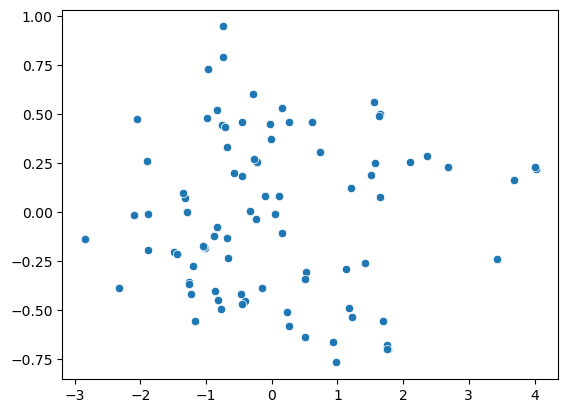

In [22]:
import seaborn as sns
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pcs = pca.fit_transform(rsxs.detach().numpy())

sns.scatterplot(x=pcs[:, 0], y=pcs[:, 1])

In [23]:
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(n_neighbors=4).fit(rsxs.detach().numpy())
knn.kneighbors(rsxs[30].detach().reshape(1, -1), return_distance=False)

array([[30,  8, 56,  6]])

In [24]:
IPythonConsole.drawMol3D(rss[30])
IPythonConsole.drawMol3D(rss[8])
IPythonConsole.drawMol3D(rss[56])

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [63]:
lstm = nn.LSTM(10, 20, 4)
x = torch.randn(100, 10)

In [ ]:
h, s = lstm.forward(x)
h

torch.Size([100, 20])

In [62]:
lstm.forward(x, s)

(tensor([[-0.0525, -0.0571,  0.0385,  ..., -0.0081,  0.0175,  0.1001],
         [ 0.0322, -0.0394, -0.0159,  ...,  0.0766,  0.1541,  0.1743],
         [-0.2353, -0.1752, -0.0386,  ..., -0.1775, -0.0704,  0.0820],
         ...,
         [ 0.1760, -0.0525, -0.2538,  ...,  0.0552,  0.1396,  0.0465],
         [-0.1046, -0.0082, -0.2883,  ..., -0.0496,  0.0014,  0.1604],
         [ 0.0317, -0.0455,  0.0217,  ...,  0.1513,  0.1305,  0.1429]],
        grad_fn=<SqueezeBackward1>),
 (tensor([[ 0.0317, -0.0455,  0.0217,  0.0805,  0.0263, -0.0540,  0.0900, -0.0477,
           -0.0007, -0.2500,  0.0469, -0.1687, -0.0918,  0.0160,  0.0715, -0.0816,
            0.3123,  0.1513,  0.1305,  0.1429]], grad_fn=<SqueezeBackward1>),
  tensor([[ 0.1374, -0.0811,  0.0380,  0.1889,  0.0661, -0.1661,  0.2801, -0.1207,
           -0.0018, -0.3261,  0.0814, -0.4646, -0.3284,  0.0302,  0.1227, -0.1482,
            0.5949,  0.3548,  0.2618,  0.3341]], grad_fn=<SqueezeBackward1>)))

In [56]:
lstm.forward(torch.randn(100, 10))

(tensor([[-0.0703,  0.0428,  0.1800,  ..., -0.0210, -0.2877,  0.0613],
         [-0.1013, -0.0081, -0.1667,  ...,  0.0061, -0.1745,  0.0566],
         [-0.0644, -0.1273, -0.0225,  ...,  0.0335, -0.0829, -0.0045],
         ...,
         [-0.0529,  0.0177,  0.1491,  ..., -0.0621, -0.1960,  0.3746],
         [-0.2014,  0.0593,  0.0248,  ...,  0.0333,  0.0382, -0.1322],
         [-0.2701,  0.0830,  0.1306,  ..., -0.1056, -0.1556,  0.1402]],
        grad_fn=<SqueezeBackward1>),
 (tensor([[-0.2701,  0.0830,  0.1306, -0.0162, -0.0139,  0.1608,  0.0859,  0.1055,
           -0.1505, -0.0091,  0.0663, -0.0626, -0.1543,  0.0490,  0.0343, -0.0616,
            0.0113, -0.1056, -0.1556,  0.1402]], grad_fn=<SqueezeBackward1>),
  tensor([[-0.5152,  0.3017,  0.2508, -0.0303, -0.0581,  0.3139,  0.2053,  0.2394,
           -0.2394, -0.0176,  0.1284, -0.1908, -0.4526,  0.1136,  0.0726, -0.1071,
            0.0335, -0.1901, -0.3309,  0.1885]], grad_fn=<SqueezeBackward1>)))

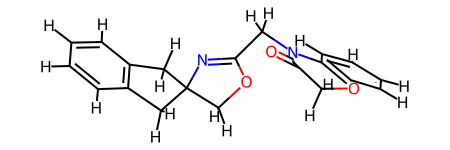

In [ ]:
IPythonConsole.drawMol3D(ps[0])

In [31]:
IPythonConsole.drawMol3D(result[0]+[result[1]])

3Dmol.js failed to load for some reason. Please check your browser console for error messages.